# Global Greening

## Installing & Importing Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from patchify import patchify
import albumentations as A
from IPython.display import SVG
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

from sklearn.preprocessing import MinMaxScaler

/Users/Alenka/.pyenv/versions/3.10.6/envs/GlobalGreening/lib/python3.10/site-packages/tensorflow_io-0.32.0-py3.10-macosx-13.3-arm64.egg/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/Alenka/.pyenv/versions/3.10.6/envs/GlobalGreening/lib/python3.10/site-packages/tensorflow_io-0.32.0-py3.10-macosx-13.3-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/Alenka/.pyenv/versions/3.10.6/envs/GlobalGreening/lib/python3.10/site-packages/tensorflow_io-0.32.0-py3.10-macosx-13.3-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/Alenka/.pyenv/versions/3.10.6/envs/GlobalGreening/lib/python3.10/site-packages/tensorflow_io-0.32.0-py3.10-macosx-13.3-arm64.egg/tensorflow_io/python/ops/__init__

## Prepara Data Augmentation

**Augmentation using Albumentations Library**

[Albumentations](https://albumentations.ai/) is a Python library for fast and flexible image augmentations. Albumentations efficiently implements a rich variety of image transform operations that are optimized for performance, and does so while providing a concise, yet powerful image augmentation interface for different computer vision tasks, including object classification, segmentation, and detection.

Data augmentation is done by the following techniques:

1. Random Cropping - left out since we will have same size pictures
2. Horizontal Flipping
3. Vertical Flipping
4. Rotation
5. Random Brightness & Contrast
6. Contrast Limited Adaptive Histogram Equalization (CLAHE)
7. Grid Distortion
8. Optical Distortion

In [2]:
# function to augment
def augment(): #width, height
    transform = A.Compose([
#        A.RandomCrop(width=width, height=height, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Rotate(limit=[60, 300], p=1.0, interpolation=cv2.INTER_NEAREST),
        A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.3], contrast_limit=0.2, p=1.0),
        A.OneOf([
            A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),
        ], p=1.0),
    ], p=1.0)
    
    return transform

In [3]:
# visualize the augmentations

def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 16

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(10, 10)) 

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 12))  

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original Image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original Mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed Image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed Mask', fontsize=fontsize)
        
    plt.savefig('sample_augmented_image.png', facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)

## Loading the Data

In [4]:
# check where we are
!pwd

/Users/Alenka/code/Alastair908/GlobalGreening


In [5]:
# load the data
dataset_root_folder = '/Users/Alenka/code/Alastair908/Downloads'
dataset_name = 'Dubai_data'

In [6]:
# loading images and masks into the list - new version wihtout cv2.

images_dataset = []
masks_dataset = []

for image_type in ['images' , 'masks']:
    for tile_id in range(1,9):
        for image_id in range(1,10):                    
            if image_type == 'images':
                image_extension = 'jpg'
                path_image = f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}'
                print(path_image)
                image = Image.open(path_image)
                image = image.resize((512,512))
                images_dataset.append(np.array(image))
                print('appended image')
            elif image_type == 'masks':
                image_extension = 'png'
                path_mask = f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}'
                print(path_mask)
                mask = Image.open(path_mask)
                mask = mask.resize((512,512)).convert('RGB')
                masks_dataset.append(np.array(mask))
                print('appended mask')

/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_001.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_002.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_003.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_004.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_005.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_006.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_007.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_008.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_009.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 2/images/image_part_001.jpg
appended image


appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 5/masks/image_part_002.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 5/masks/image_part_003.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 5/masks/image_part_004.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 5/masks/image_part_005.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 5/masks/image_part_006.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 5/masks/image_part_007.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 5/masks/image_part_008.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 5/masks/image_part_009.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_001.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_002.png
appended mask
/Users

In [7]:
len(images_dataset), len(masks_dataset)

(72, 72)

In [8]:
image = images_dataset[0] 
mask = masks_dataset[0] 

print(image.shape, mask.shape, type(image))

(512, 512, 3) (512, 512, 3) <class 'numpy.ndarray'>


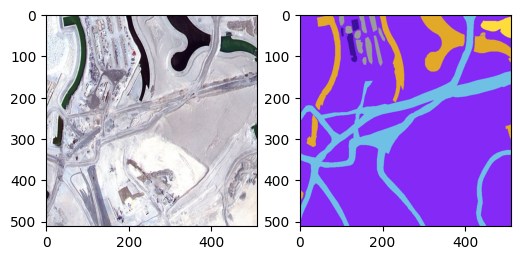

In [9]:
f, ax = plt.subplots(1, 2, figsize=(6, 6)) 
ax[0].imshow(images_dataset[0])
ax[1].imshow(masks_dataset[0])

In [ ]:
# this piece of code causing trouble
# visualize(image, mask)

## Image masks

The images are densely labeled and contain the following 6 classes:

| Name       | R   | G   | B   | Color                                                                                              |
| ---------- | --- | --- | --- | -------------------------------------------------------------------------------------------------- |
| Building   | 60  | 16  | 152 | <p align="center"><div style="background-color: rgb(60, 16, 152); padding: 10px; "/></p>   |
| Land       | 132 | 41  | 246 | <p align="center"><div style="background-color: rgb(132, 41, 246); padding: 10px; "/></p>   |
| Road       | 110 | 193 | 228 | <p align="center"><div style="background-color: rgb(110, 193, 228); padding: 10px; "/></p>   |
| Vegetation | 254 | 221 | 58  | <p align="center"><div style="background-color: rgb(254, 221, 58); padding: 10px; "/></p>   |
| Water      | 226 | 169 | 41  | <p align="center"><div style="background-color: rgb(226, 169, 41); padding: 10px; "/></p>   |
| Unlabeled  | 155 | 155 | 155 | <p align="center"><div style="background-color: rgb(155, 155, 155); padding: 10px; "/></p>   |


## Perform Augmentation

In [10]:
transform = augment()
transformed = transform(image=image, mask=mask)
transformed_image = transformed['image']
transformed_mask = transformed['mask']

visualize(transformed_image, transformed_mask, image, mask)

In [11]:
def augment_dataset(count):
    '''Function for data augmentation
        Input:
            count - total no. of images after augmentation = initial no. of images * count
        Output:
            writes augmented images (input images & segmentation masks) to the working directory
    '''
    transform = augment() 
    aug_images_dataset = []
    aug_masks_dataset = []
    
    i = 0
    for i in range(count):
        for j in range(len(images_dataset)):
            img = images_dataset[j]
            msk = masks_dataset[j] 
            
            transformed = transform(image=img, mask=msk)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask'] 
       
            aug_images_dataset.append(transformed_image)
            aug_masks_dataset.append(transformed_mask)
    return aug_images_dataset, aug_masks_dataset 

In [12]:
aug_images_dataset, aug_masks_dataset  = augment_dataset(8)

In [13]:
len(images_dataset), len(masks_dataset), len(aug_images_dataset), len(aug_masks_dataset)

(72, 72, 576, 576)

In [14]:
image_sizes = []

for i in range(len(images_dataset)):
    image_sizes.append(images_dataset[i].shape)

image_sizes
min(image_sizes), max(image_sizes)

((512, 512, 3), (512, 512, 3))

In [16]:
mask_sizes = []

for i in range(len(masks_dataset)):
    mask_sizes.append(masks_dataset[i].shape)

mask_sizes
min(mask_sizes), max(mask_sizes)

((512, 512, 3), (512, 512, 3))

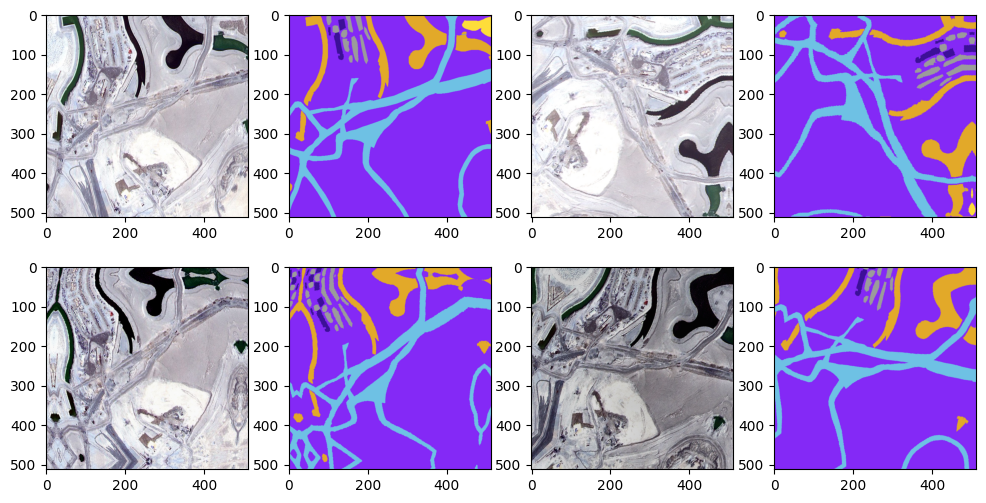

In [17]:
# show first 3 augmented images + masks for first image 

f, ax = plt.subplots(2, 4, figsize=(12, 6)) 

ax[0,0].imshow(images_dataset[0])
ax[0,1].imshow(masks_dataset[0])

ax[0,2].imshow(aug_images_dataset[0])
ax[0,3].imshow(aug_masks_dataset[0])

ax[1,0].imshow(aug_images_dataset[72])
ax[1,1].imshow(aug_masks_dataset[72])

ax[1,2].imshow(aug_images_dataset[144])
ax[1,3].imshow(aug_masks_dataset[144])


## Preparing labels

In [18]:
#labels_dict = {"classes": [{"title": "Water", "shape": "polygon", "color": "#50E3C2", "geometry_config": {}}, {"title": "Land (unpaved area)", "shape": "polygon", "color": "#F5A623", "geometry_config": {}}, {"title": "Road", "shape": "polygon", "color": "#DE597F", "geometry_config": {}}, {"title": "Building", "shape": "polygon", "color": "#D0021B", "geometry_config": {}}, {"title": "Vegetation", "shape": "polygon", "color": "#417505", "geometry_config": {}}, {"title": "Unlabeled", "shape": "polygon", "color": "#9B9B9B", "geometry_config": {}}]}
labels_dict = {"classes": [{"title": "Water", "r": 226, "g": 169, "b": 41 }, 
                           {"title": "Land", "r": 132, "g": 41, "b": 246 }, 
                           {"title": "Road", "r": 110, "g": 193, "b": 228 }, 
                           {"title": "Building", "r": 60, "g": 16, "b": 152 }, 
                           {"title": "Vegetation", "r": 254, "g": 221, "b": 58 }, 
                           {"title": "Unlabeled", "r": 155, "g": 155, "b": 155 }]}

labels_dict_df = pd.DataFrame(labels_dict['classes'])
labels_dict_df

,title,r,g,b
0,Water,226,169,41
1,Land,132,41,246
2,Road,110,193,228
3,Building,60,16,152
4,Vegetation,254,221,58
5,Unlabeled,155,155,155


In [19]:
label_names= list(labels_dict_df.title)
label_codes = []
r= np.asarray(labels_dict_df.r)
g= np.asarray(labels_dict_df.g)
b= np.asarray(labels_dict_df.b)

for i in range(len(labels_dict_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))
    
label_codes, label_names

([(226, 169, 41),
  (132, 41, 246),
  (110, 193, 228),
  (60, 16, 152),
  (254, 221, 58),
  (155, 155, 155)],
 ['Water', 'Land', 'Road', 'Building', 'Vegetation', 'Unlabeled'])

In [20]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [21]:
id2code

{0: (226, 169, 41),
 1: (132, 41, 246),
 2: (110, 193, 228),
 3: (60, 16, 152),
 4: (254, 221, 58),
 5: (155, 155, 155)}

In [22]:
id2name

{0: 'Water',
 1: 'Land',
 2: 'Road',
 3: 'Building',
 4: 'Vegetation',
 5: 'Unlabeled'}

## Function to One-hot Encode RGB Labels/Masks and Decoding Encoded Predictions

In [23]:
def rgb_to_onehot(rgb_mask_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    # shape prepared for image size and channels = num of classes (instead of 3 RGB colors)
    shape = rgb_mask_image.shape[:2]+(num_classes,)
    # encoded_image prepare array with right shaoe 
    encoded_mask = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        # image.reshape flattens and keeps 3 channels, 
        # then checks which pixels same as color in colormap
        # then change back to image size for each of 6 channels (based on colormap)
        encoded_mask[:,:,i] = np.all(rgb_mask_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])

    return encoded_mask

In [24]:
def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

mask shape is RGB image (512, 512, 3)
encoded mask is 6 channel array (512, 512, 6)


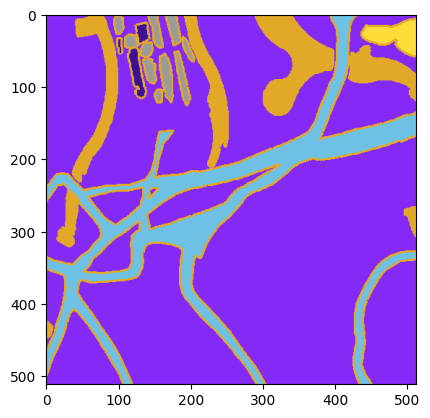

In [25]:
# checking that it works
print(f'mask shape is RGB image {mask.shape}')
encoded_mask = rgb_to_onehot(mask, colormap = id2code)
decoded_mask = onehot_to_rgb(encoded_mask, colormap = id2code)
plt.imshow(decoded_mask);
print(f'encoded mask is 6 channel array {encoded_mask.shape}')

**Input on loading and preprocessing Images**

Deprecated: tf.keras.preprocessing.image.ImageDataGenerator is not recommended for new code. Prefer loading images with tf.keras.utils.image_dataset_from_directory and transforming the output tf.data.Dataset with preprocessing layers. For more information, see the tutorials for loading images and augmenting images, as well as the preprocessing layer guide.


we will use function [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

and resize with [keras.layers.resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing)

did resizing on import with Pillow.Image

## Model

In [26]:
# files to use
len(images_dataset), len(masks_dataset), len(aug_images_dataset), len(aug_masks_dataset)

(72, 72, 576, 576)

In [27]:
# files to use
images_dataset[0].shape, masks_dataset[0].shape, aug_images_dataset[0].shape, aug_masks_dataset[0].shape

((512, 512, 3), (512, 512, 3), (512, 512, 3), (512, 512, 3))

In [28]:
#generate list of images and masks
image_full_dataset = images_dataset + aug_images_dataset
image_full_dataset_np = np.array(image_full_dataset)

masks_full_dataset = masks_dataset + aug_masks_dataset
#masks_full_dataset_np = np.array(masks_full_dataset)

#### Problem solving - delete later

In [ ]:
image_full_dataset = images_dataset + aug_images_dataset
len(image_full_dataset), type(image_full_dataset), type(image_full_dataset[0]), image_full_dataset[0].dtype

In [ ]:
masks_full_dataset = masks_dataset + aug_masks_dataset
len(masks_full_dataset ), type(masks_full_dataset ), type(masks_full_dataset[0]), masks_full_dataset[0].dtype

In [ ]:
image_full_dataset_np = np.array(image_full_dataset)
len(image_full_dataset_np), type(image_full_dataset_np), type(image_full_dataset_np[0]), image_full_dataset_np[0].dtype

In [ ]:
masks_full_dataset_np = np.array(masks_full_dataset)
#len(masks_full_dataset_), type(masks_full_dataset ), type(masks_full_dataset[0]), masks_full_dataset[0].dtype

In [ ]:
masks_full_dataset

In [ ]:
len(image_full_dataset), image_full_dataset[0].shape, image_full_dataset_np.shape

In [ ]:
type(masks_full_dataset)
len(masks_full_dataset), masks_full_dataset[0].shape

In [ ]:
image_full_dataset[0]

In [ ]:
plt.imshow(masks_full_dataset[0])

In [ ]:
mask1 = masks_dataset[0]
mask2 = masks_dataset[10]
encoded_mask1 = rgb_to_onehot(mask1)
encoded_mask2 = rgb_to_onehot(mask2)
mask1.shape, encoded_mask2.shape
mask2.shape, encoded_mask2.shape

#### Back to modelling

In [29]:
encoded_masks = []

for i in range(len(masks_full_dataset)):
    mask = masks_full_dataset[i]
    encoded_mask = rgb_to_onehot(mask)
    encoded_masks.append(encoded_mask)

In [38]:
y = np.array(encoded_masks) 
X = np.array(image_full_dataset)/255.
len(y), len(X)

(648, 648)

In [43]:
X[0].shape

(512, 512, 3)

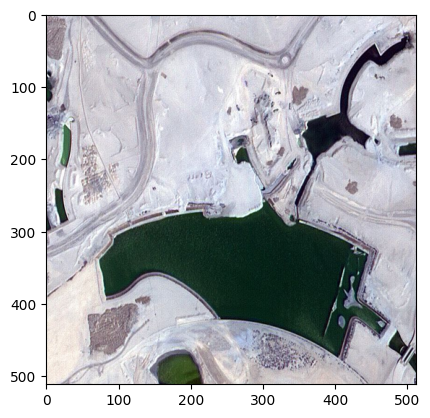

In [45]:
plt.imshow(X[1])

In [46]:
# Preparing X(images) and y(labels) - to be added to load images later

# Finally we shuffle:
p = np.random.permutation(len(X))
X, y = X[p], y[p]

# first split is for train/val data, second split for test data
first_split = int(len(X) /6.) 
X_test, X_train_val = X[:first_split], X[first_split:]
y_test, y_train_val = y[:first_split], y[first_split:] 

### InceptionResNetV2 UNet

In [34]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(6, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model

In [35]:
K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

Model: "InceptionResNetV2-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                            

                                                                                                  
 conv2d_10 (Conv2D)             (None, 61, 61, 96)   82944       ['activation_9[0][0]']           
                                                                                                  
 conv2d_11 (Conv2D)             (None, 61, 61, 64)   12288       ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 61, 61, 96)  288         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 61, 61, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
          

 conv2d_21 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 batch_normalization_21 (BatchN  (None, 61, 61, 32)  96          ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_21 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_21[0][0]'] 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)             (None, 61, 61, 48)   13824       ['activation_21[0][0]']          
          

 batch_normalization_26 (BatchN  (None, 61, 61, 32)  96          ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_29 (BatchN  (None, 61, 61, 64)  192         ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 activation_26 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_26[0][0]'] 
                                                                                                  
 activatio

 conv2d_37 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_4_ac[0][0]']           
                                                                                                  
 conv2d_40 (Conv2D)             (None, 61, 61, 48)   13824       ['activation_39[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 61, 61, 32)  96          ['conv2d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_40 (BatchN  (None, 61, 61, 48)  144         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 activation_44 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 activation_47 (Activation)     (None, 61, 61, 64)   0           ['batch_normalization_47[0][0]'] 
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 61, 61, 128)  0           ['activation_42[0][0]',          
                                                                  'activation_44[0][0]',          
                                                                  'activation_47[0][0]']          
                                                                                                  
 block35_6_conv (Conv2D)        (None, 61, 61, 320)  41280       ['block35_6_mixed[0][0]']        
          

 batch_normalization_58 (BatchN  (None, 61, 61, 48)  144         ['conv2d_58[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 61, 61, 32)   0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 activation_58 (Activation)     (None, 61, 61, 48)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 conv2d_54 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_56 (Conv2D)             (None, 61, 61, 32)   9216        ['activation_55[0][0]']          
          

                                                                  'activation_65[0][0]']          
                                                                                                  
 block35_9_conv (Conv2D)        (None, 61, 61, 320)  41280       ['block35_9_mixed[0][0]']        
                                                                                                  
 custom_scale_layer_8 (CustomSc  (None, 61, 61, 320)  0          ['block35_8_ac[0][0]',           
 aleLayer)                                                        'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 61, 61, 320)  0           ['custom_scale_layer_8[0][0]']   
                                                                                                  
 conv2d_69 (Conv2D)             (None, 61, 61, 32)   10240       ['block35_9_ac[0][0]']           
          

 batch_normalization_75 (BatchN  (None, 30, 30, 384)  1152       ['conv2d_75[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_72 (Activation)     (None, 30, 30, 384)  0           ['batch_normalization_72[0][0]'] 
                                                                                                  
 activation_75 (Activation)     (None, 30, 30, 384)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 30, 30, 320)  0          ['block35_10_ac[0][0]']          
                                                                                                  
 mixed_6a (Concatenate)         (None, 30, 30, 1088  0           ['activation_72[0][0]',          
          

                                                                                                  
 block17_2_conv (Conv2D)        (None, 30, 30, 1088  418880      ['block17_2_mixed[0][0]']        
                                )                                                                 
                                                                                                  
 custom_scale_layer_11 (CustomS  (None, 30, 30, 1088  0          ['block17_1_ac[0][0]',           
 caleLayer)                     )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 30, 30, 1088  0           ['custom_scale_layer_11[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_85

                                                                                                  
 custom_scale_layer_13 (CustomS  (None, 30, 30, 1088  0          ['block17_3_ac[0][0]',           
 caleLayer)                     )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 30, 30, 1088  0           ['custom_scale_layer_13[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 30, 30, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_93 (BatchN  (None, 30, 30, 128)  384        ['conv2d_93[0][0]']              
 ormalizat

                                                                                                  
 block17_6_ac (Activation)      (None, 30, 30, 1088  0           ['custom_scale_layer_15[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_101 (Conv2D)            (None, 30, 30, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_101 (Batch  (None, 30, 30, 128)  384        ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_101 (Activation)    (None, 30, 30, 128)  0           ['batch_normalization_101[0][0]']
          

                                                                                                  
 conv2d_109 (Conv2D)            (None, 30, 30, 128)  139264      ['block17_8_ac[0][0]']           
                                                                                                  
 batch_normalization_109 (Batch  (None, 30, 30, 128)  384        ['conv2d_109[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_109 (Activation)    (None, 30, 30, 128)  0           ['batch_normalization_109[0][0]']
                                                                                                  
 conv2d_110 (Conv2D)            (None, 30, 30, 160)  143360      ['activation_109[0][0]']         
                                                                                                  
 batch_nor

 batch_normalization_117 (Batch  (None, 30, 30, 128)  384        ['conv2d_117[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_117 (Activation)    (None, 30, 30, 128)  0           ['batch_normalization_117[0][0]']
                                                                                                  
 conv2d_118 (Conv2D)            (None, 30, 30, 160)  143360      ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 30, 30, 160)  480        ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 activation_125 (Activation)    (None, 30, 30, 128)  0           ['batch_normalization_125[0][0]']
                                                                                                  
 conv2d_126 (Conv2D)            (None, 30, 30, 160)  143360      ['activation_125[0][0]']         
                                                                                                  
 batch_normalization_126 (Batch  (None, 30, 30, 160)  480        ['conv2d_126[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_126 (Activation)    (None, 30, 30, 160)  0           ['batch_normalization_126[0][0]']
                                                                                                  
 conv2d_124 (Conv2D)            (None, 30, 30, 192)  208896      ['block17_12_ac[0][0]']          
          

                                                                                                  
 batch_normalization_134 (Batch  (None, 30, 30, 160)  480        ['conv2d_134[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_134 (Activation)    (None, 30, 30, 160)  0           ['batch_normalization_134[0][0]']
                                                                                                  
 conv2d_132 (Conv2D)            (None, 30, 30, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_135 (Conv2D)            (None, 30, 30, 192)  215040      ['activation_134[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_142 (Activation)    (None, 30, 30, 160)  0           ['batch_normalization_142[0][0]']
                                                                                                  
 conv2d_140 (Conv2D)            (None, 30, 30, 192)  208896      ['block17_16_ac[0][0]']          
                                                                                                  
 conv2d_143 (Conv2D)            (None, 30, 30, 192)  215040      ['activation_142[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 30, 30, 192)  576        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_148 (Conv2D)            (None, 30, 30, 192)  208896      ['block17_18_ac[0][0]']          
                                                                                                  
 conv2d_151 (Conv2D)            (None, 30, 30, 192)  215040      ['activation_150[0][0]']         
                                                                                                  
 batch_normalization_148 (Batch  (None, 30, 30, 192)  576        ['conv2d_148[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_151 (Batch  (None, 30, 30, 192)  576        ['conv2d_151[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

 conv2d_transpose (Conv2DTransp  (None, 64, 64, 512)  590336     ['zero_padding2d_3[0][0]']       
 ose)                                                                                             
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 64, 64, 256)  0          ['activation_74[0][0]']          
 D)                                                                                               
                                                                                                  
 concatenate (Concatenate)      (None, 64, 64, 768)  0           ['conv2d_transpose[0][0]',       
                                                                  'zero_padding2d_2[0][0]']       
                                                                                                  
 conv2d_203 (Conv2D)            (None, 64, 64, 512)  3539456     ['concatenate[0][0]']            
          

 conv2d_209 (Conv2D)            (None, 512, 512, 64  38656       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_209 (Batch  (None, 512, 512, 64  256        ['conv2d_209[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 activation_209 (Activation)    (None, 512, 512, 64  0           ['batch_normalization_209[0][0]']
                                )                                                                 
                                                                                                  
 conv2d_210 (Conv2D)            (None, 512, 512, 64  36928       ['activation_209[0][0]']         
          

In [47]:
# graph the model
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

### Modelling

In [37]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

# save the model
checkpoint = ModelCheckpoint(
    filepath = 'InceptionResNetV2-UNet.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [49]:
batch_size = 16

steps_per_epoch = np.ceil(float(len(X_train_val)*0.8) / float(batch_size))
print('steps_per_epoch: ', steps_per_epoch)

validation_steps = np.ceil(float(len(X_train_val)*0.2) / float(batch_size))
print('validation_steps: ', validation_steps)

steps_per_epoch:  27.0
validation_steps:  7.0


In [ ]:
history = model.fit(
    X_train_val, 
    y_train_val,
    batch_size=batch_size,
    validation_split = 0.2, 
    epochs = 50,
    callbacks=callbacks, 
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 0.9913 - dice_coef: 0.3962 - accuracy: 0.5905 
Epoch 1: val_loss improved from inf to 1.41054, saving model to InceptionResNetV2-UNet.h5
27/27 [==============================] - 1275s 47s/step - loss: 0.9913 - dice_coef: 0.3962 - accuracy: 0.5905 - val_loss: 1.4105 - val_dice_coef: 0.1961 - val_accuracy: 0.5895 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.623506263980886e-05.
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 0.7318 - dice_coef: 0.5259 - accuracy: 0.6705  
Epoch 2: val_loss improved from 1.41054 to 1.22210, saving model to InceptionResNetV2-UNet.h5
27/27 [==============================] - 4481s 171s/step - loss: 0.7318 - dice_coef: 0.5259 - accuracy: 0.6705 - val_loss: 1.2221 - val_dice_coef: 0.2558 - val_accuracy: 0.6587 - lr: 9.6235e-05

Epoch 3: LearningRateScheduler setting learning rate

### Sandbox

In [ ]:
tf.keras.layers.Resizing(
    height,
    width,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
    **kwargs
)

preprocessing = 
tf.keras.layers.CenterCrop(
    512, 512)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
for element in dataset:
  print(element)

tf.keras.preprocessing.image.smart_resize(
    x, size, interpolation='bilinear'
)

size = (512, 512)
ds = ds.map(lambda img: tf.image.resize(img, size))